In [1]:
import pandas as pd
import os,copy
import tqdm
import pickle
from gensim.models import Word2Vec
from fuzzywuzzy import fuzz
from scipy import spatial
import numpy as np
from collections import Counter  
import re
import sys
import stanza.protobuf.CoreNLP_pb2 as CoreNLP_pb2
sys.modules['CoreNLP_pb2'] = CoreNLP_pb2
from ast import literal_eval
from collections import Counter
import functools
import itertools
import matplotlib.pyplot as plt
import glob
import networkx as nx
import cdlib
from cdlib import algorithms


tactic_dic = {
    0: 'Initial Access', 
    1: 'Execution', 
    2: 'Defense Evasion', 
    3: 'Command and Control', 
    4: 'Privilege Escalation', 
    5: 'Persistence', 
    6: 'Lateral Movement', 
    7: 'DataLeak', 
    8: 'Exfiltration', 
    9: 'Impact'
}


def extract_subgraph(g, nodes):
    # Extract a subgraph of g induced by nodes
    sg = g.subgraph(nodes)
    # Initialize sets to store the tactics and articles that are part of the subgraph
    sg_tactics = set()
    sg_articles = set()
    # Initialize a set to store the nodes that are linking nodes in the subgraph
    sg_linking_nodes = set()
    
    edge_labels = {}
    edge_mentions = []
    node2article = dict()
    # Iterate over edges of the subgraph
    for edge in sg.edges(data=True):
        # Extract mentions
        mentions = edge[2]['mentions']
        # Update articles
        sg_articles.update(map(lambda x: x.article_id, mentions))
        # Update tactics
        for mention in mentions:
            for tac in mention.tactic:
                sg_tactics.add(tac)
        # Fill node2article dictionary
        if edge[0] not in node2article:
            node2article[edge[0]] = set()
        node2article[edge[0]].update(map(lambda x: x.article_id, mentions))
        if edge[1] not in node2article:
            node2article[edge[1]] = set()
        node2article[edge[1]].update(map(lambda x: x.article_id, mentions))
        
    # Find linking nodes
    for k, v in node2article.items():
        if len(v)>1:
            sg_linking_nodes.add(k)
            
    return sg, sg_tactics, sg_articles, sg_linking_nodes

def draw_graph(g, scheme=False, legend=False):
    node_deg = nx.degree(g)
    layout = nx.spring_layout(g, k=2, iterations=80)
    plt.figure(num=None, figsize=(30, 30), dpi=100)

    if scheme:
        node_labels = {node[0] : f"{node[0]}" for node in g.nodes(data=True)}
    else:
        node_labels = {node[0] : f"{node[0]}\n({node[1]['ent']})" for node in g.nodes(data=True)}
    nx.draw_networkx(
        g,
        node_size=[int(deg[1]) * 1000 for deg in node_deg],
        arrowsize=10,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        node_shape="s",
        bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.1'),
        node_color='white',
        font_size=13,
        with_labels=True,
        labels = node_labels,
        )

    edge_labels = {}
    edge_mentions = []
    for edge in g.edges(data=True):
        mentions = edge[2]['mentions']
        mention_articles = ','.join(map(lambda x: str(x.article_id), mentions))
        mention_tactics = set()
        for mention in mentions:
            if len(mention.tactic)>0:
                for tac in mention.tactic: 
                    mention_tactics.add(tactic_dic[tac])
        mention_tactics = '('+','.join(mention_tactics)+')'
        
        edge_labels[(edge[0], edge[1])] = '-'.join([mention_tactics, edge[2]['relation'], mention_articles])
        edge_mentions.append(mentions)
    edge_mentions = [item for sublist in edge_mentions for item in sublist]
    descriptions = set([x.article_id for x in edge_mentions])
    
    #texts = ['::'.join([str(x), articles.loc[x]['title'], articles.loc[x]['date']]) for x in descriptions]
    nx.draw_networkx_edge_labels(g,
                                 pos=layout, 
                                 edge_labels=edge_labels,
                                 font_color='red',
                                 font_size=16,)
    #if legend:
        #plt.legend(texts, fontsize=10)

class Triple():
    def __init__(self, sub, rel, obj, sub_ent='', rel_ent='', obj_ent='', sub_ent_conf=0, obj_ent_conf=0, conf=0):
        self.sub = sub.lower()
        self.rel = rel.lower()
        self.obj = obj.lower()
        self.sub_ent = sub_ent
        self.rel_ent = rel_ent
        self.obj_ent = obj_ent
        self.sub_ent_conf = sub_ent_conf
        self.obj_ent_conf = obj_ent_conf
        self.confidence = conf

    def __hash__(self):
        return hash(self.sub + self.rel + self.obj+self.confidence+self.sub_ent+self.obj_ent)

    def set_raw_article_doc(self, doc):
        self.article_doc = doc

    def set_raw_sent(self, sent):
        self.raw_sent = sent

    def set_raw_triple(self, triple_obj):
        self.triple_obj = triple_obj

    def set_sent_ind(self, sent_ind):
        self.sent_ind = sent_ind

    def set_article_ref(self, article):
        self.article_id = article

    def set_tactic(self, tactic):
        self.tactic = tactic

    def set_tactic_conf(self, tactic_conf):
        self.tactic_conf = tactic_conf

    def set_behave_conf(self, behave_conf):
        self.behave_conf = behave_conf

    def set_relative_sent_ind(self, relative_sent_order):
        self.relative_sent_order = relative_sent_order

    def set_count(self, count):
        self.count = count

    def add_cluster(self, cluster):
        self.from_cluster = set()
        self.from_cluster.add(cluster)

    def __eq__(self, other):
        sub_eq = False
        if self.sub in other.sub or other.sub in self.sub:
            sub_eq = True
        elif fuzz.ratio(self.sub, other.sub) > 90:
            sub_eq = True
        else:
            self_sub_tokens = self.sub.split(' ')
            other_sub_tokens = other.sub.split(' ')
            if all(map(lambda x: x in w2v.wv, self_sub_tokens)) and all(map(lambda x: x in w2v.wv, other_sub_tokens)):
                self_sub_vec = np.mean([w2v.wv[x] for x in self_sub_tokens], axis=0)
                other_sub_vec = np.mean([w2v.wv[x] for x in other_sub_tokens], axis=0)
                sub_eq = spatial.distance.cosine(self_sub_vec, other_sub_vec) < 0.3

        rel_eq = False
        if self.rel in other.rel or other.rel in self.rel:
            rel_eq = True
        elif self.rel == other.rel:
            rel_eq = True
        else:
            self_rel_tokens = self.rel.split(' ')
            other_rel_tokens = other.rel.split(' ')
            if all(map(lambda x: x in w2v.wv, self_rel_tokens)) and all(map(lambda x: x in w2v.wv, other_rel_tokens)):
                self_rel_vec = np.mean([w2v.wv[x] for x in self_rel_tokens], axis=0)
                other_rel_vec = np.mean([w2v.wv[x] for x in other_rel_tokens], axis=0)
                rel_eq = spatial.distance.cosine(self_rel_vec, other_rel_vec) < 0.3

        obj_eq = False
        if self.obj in other.obj or other.obj in self.obj:
            obj_eq = True
        elif fuzz.ratio(self.obj, other.obj) > 90:
            obj_eq = True
        else:
            self_obj_tokens = self.obj.split(' ')
            other_obj_tokens = other.obj.split(' ')
            if all(map(lambda x: x in w2v.wv, self_obj_tokens)) and all(map(lambda x: x in w2v.wv, other_obj_tokens)):
                self_obj_vec = np.mean([w2v.wv[x] for x in self_obj_tokens], axis=0)
                other_obj_vec = np.mean([w2v.wv[x] for x in other_obj_tokens], axis=0)
                obj_eq = spatial.distance.cosine(self_obj_vec, other_obj_vec) < 0.3

        return sub_eq and rel_eq and obj_eq and self.sub_ent == other.sub_ent and self.obj_ent == other.obj_ent and self.rel_ent == other.rel_ent

    def print(self):
        print(f'{self.sub}({self.sub_ent}) >> {self.rel} >> {self.obj}({self.obj_ent})')

def build_graph(triples):
    g = nx.MultiDiGraph()
    for triple in triples:
        if triple.sub not in g.nodes:
            s = []
            s.append(triple)
            g.add_node(triple.sub, appearance=1, ent=triple.sub_ent, mentions=s)
        else:
            g.nodes[triple.sub]['appearance'] += 1
            g.nodes[triple.sub]['mentions'].append(triple)

        if triple.obj not in g.nodes:
            s = []
            s.append(triple)
            g.add_node(triple.obj, appearance=1, ent=triple.obj_ent, mentions=s)
        else:
            g.nodes[triple.obj]['appearance'] += 1
            g.nodes[triple.obj]['mentions'].append(triple)

        if not g.has_edge(triple.sub, triple.obj):
            s = []
            s.append(triple)
            g.add_edge(triple.sub, triple.obj, appearance=1, relation=triple.rel, mentions=s)
        elif g[triple.sub][triple.obj][0]['relation'] == triple.rel:
            g[triple.sub][triple.obj][0]['appearance'] += 1
            g[triple.sub][triple.obj][0]['mentions'].append(triple)
        else:
            s = []
            s.append(triple)
            g.add_edge(triple.sub, triple.obj, appearance=1, relation=triple.rel, mentions=s)
    return g


def search_subgraph(keywords,triples:list,jump_length,allow_noentity_of_keywordedge,print_force_rename= False,draw= False):
    # Convert triples to a dictionary mapping each triple to its raw sentence
    for node_name in keywords:
        marked_triples = []     
        length = 0
        marked_triples_sents_obj_sub_rel = set()
        linked_nodes = set()
        while length < jump_length:
            current_loop_linked_nodes = copy.deepcopy(linked_nodes)
            for triple in (triples):
                passlabel = False
                #if 1 in triple.tactic_conf or  triple.behave_conf>=0.5 or (node_name in triple.sub or node_name in triple.obj):
                #if node_name in triple.sub or node_name in triple.obj:
                    #passlabel = True
                #if 1 in triple.tactic_conf and triple.behave_conf>=0.5:
                if allow_noentity_of_keywordedge:
                    if node_name in triple.sub or node_name in triple.obj:
                        passlabel = True
                if triple.sub_ent!='' and triple.obj_ent!='':
                    passlabel = True
                #if :
                    #passlabel = True
                if passlabel:
                    #if (node_name in triple.sub or node_name in triple.obj):
                        #print(triple.sub, triple.obj)
                    # Look up the raw sentence for the triple in the dictionary
                    raw_sent = triple.raw_sent+' '+triple.sub+' '+triple.obj+' '+triple.rel

                    if raw_sent not in marked_triples_sents_obj_sub_rel:
                        if node_name in triple.sub or node_name in triple.obj:
                            linked_nodes.add(triple.sub)
                            linked_nodes.add(triple.obj)
                            marked_triples.append(triple)
                            marked_triples_sents_obj_sub_rel.add(raw_sent)
                        else:
                            if triple.sub in current_loop_linked_nodes or triple.obj in current_loop_linked_nodes:
                                #print(triple.sub, triple.obj)
                                if triple.sub not in linked_nodes:
                                    linked_nodes.add(triple.sub)
                                if triple.obj not in linked_nodes:
                                    linked_nodes.add(triple.obj)
                                marked_triples.append(triple)
                                marked_triples_sents_obj_sub_rel.add(raw_sent)
            length = length+1

        marked_triples_cti=[]
        length = 0
        marked_triples_sents_obj_sub_rel = set()
        linked_nodes = set()

        while length < jump_length:
            current_loop_linked_nodes = copy.deepcopy(linked_nodes)
            for triple in (triples):
                passlabel = False
                #if 1 in triple.tactic_conf or  triple.behave_conf>=0.5 or (node_name in triple.sub or node_name in triple.obj):
                if allow_noentity_of_keywordedge:
                    if node_name in triple.sub or node_name in triple.obj:
                        passlabel = True
                if  triple.sub_ent!='' and triple.obj_ent!='':
                    if 1 in triple.tactic_conf and triple.behave_conf>=0.5:
                        passlabel = True
                if passlabel:
                    #if (node_name in triple.sub or node_name in triple.obj):
                        #print(triple.sub, triple.obj)
                    # Look up the raw sentence for the triple in the dictionary
                    raw_sent = triple.raw_sent+' '+triple.sub+' '+triple.obj+' '+triple.rel
                    if raw_sent not in marked_triples_sents_obj_sub_rel:
                        if node_name in triple.sub or node_name in triple.obj:
                            linked_nodes.add(triple.sub)
                            linked_nodes.add(triple.obj)
                            marked_triples_cti.append(triple)
                            marked_triples_sents_obj_sub_rel.add(raw_sent)
                        else:
                            if triple.sub in current_loop_linked_nodes or triple.obj in current_loop_linked_nodes:
                                #print(triple.sub, triple.obj)
                                if triple.sub not in linked_nodes:
                                    linked_nodes.add(triple.sub)
                                if triple.obj not in linked_nodes:
                                    linked_nodes.add(triple.obj)
                                marked_triples_cti.append(triple)
                                marked_triples_sents_obj_sub_rel.add(raw_sent)
            length = length+1

        '''
        for triple in marked_triples:
            #if (1 in triple.tactic_conf and triple.behave_conf>=0.5) or (node_name in triple.sub or node_name in triple.obj):
            if 1==1:
                #if (triple.sub_ent!='' and triple.obj_ent!='') or (node_name in triple.sub or node_name in triple.obj):
                marked_triples_cti.append(triple)
            
        #print(node_name,'cti',len(marked_triples_cti), 'all',len(marked_triples))
        '''
        
        #Force merge the cve nodes
        for i in marked_triples_cti:
            if node_name in i.sub:
                if i.sub!=node_name:
                    if print_force_rename:
                        print(i.sub)
                i.sub=node_name
            if node_name in i.obj:
                if i.obj!=node_name:
                    if print_force_rename:
                        print(i.obj)
                i.obj=node_name
        

        if draw:
            kg = build_graph(marked_triples_cti)
            draw_graph(kg)

        return [node_name,len(marked_triples),len(marked_triples_cti),marked_triples,marked_triples_cti]



articles = pd.read_csv('blogs_clusterd_title_head_tail.csv', index_col='id')
triples_per_cluster = pickle.load(open('cluster_extracts_high_value.pkl', 'rb'))


Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'wurlitzer', 'infomap', 'graph_tool', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


In [2]:
#flatten the list
flat = [item for sublist in triples_per_cluster.values() for item in sublist]
all_triples = [item for sublist in flat for item in sublist]

#filter the confidence
all_triples=[item for item in all_triples if item.confidence>0.8]
#all_triples=[item for item in all_triples if item.behave_conf>0.5]

for tripe in all_triples:
    if 'cve' in tripe.sub and tripe.sub_ent=='':
        tripe.sub_ent='CVE'
    if 'cve' in tripe.obj and tripe.obj_ent=='':
        tripe.obj_ent='CVE'

#Display the number of triples in each cluster
for key in triples_per_cluster.keys():
    test_flat = triples_per_cluster[key]
    test_flat = [item for sublist in test_flat for item in sublist]
    print('triple number in ',key, len(test_flat))
#print('found in ',found_key)

def find_existing_in_cluster(cluster_triple,search_name):
    found_key=set()
    for key in cluster_triple.keys():
        test_flat = cluster_triple[key]
        test_flat = [item for sublist in test_flat for item in sublist]
        for triple in test_flat:
            if search_name in triple.sub:
                found_key.add(key)
            if search_name in triple.obj:
                found_key.add(key)
    return(list(found_key))

find_existing_in_cluster(triples_per_cluster,'cve20121889')

full_data=pd.read_csv('fulldata.csv')
#[[i.sub,i.rel,i.obj,i.article_id] for i in all_triples if 'The script ensures that sufficient user interaction has occurred from either clicking, scrolling or moving the mouse' in i.raw_sent]
count=0
allcount=0
chunk_df_dict = {k: v for k, v in full_data.groupby('hardcode_id')}
#show the progress
#for i in all_triples:

import re

def remove_non_letters(string):
    return re.sub(r"[^a-zA-Z]", "", string)


for i in tqdm.tqdm(all_triples):
    if (i.sub.lower() not in i.raw_sent.lower()) and (i.obj.lower() not in i.raw_sent.lower()):
        allcount+=1
        chunk_df=chunk_df_dict[i.article_id]
        #check sub
        in_sent=set()
        for j in chunk_df['line']:
            #if i.sub.lower() in j.lower() and i.obj.lower() in j.lower():
            if remove_non_letters(i.obj.lower()) in remove_non_letters(j.lower()) and remove_non_letters(i.sub.lower()) in remove_non_letters(j.lower()):
                in_sent.add(j)
                count+=1
                '''
            if len(ex_sent)==1:
                count+=1
                i.raw_sent=list(ex_sent)[0]
        if len(in_sent)==1:
            count+=1
            i.raw_sent=list(in_sent)[0]
        if len(in_sent)!=1:
            ex_sent=set()
            for j in chunk_df['line']:
                #if i.sub.lower() in j.lower() and i.obj.lower() in j.lower():
                if i.sub.lower() in j.lower():
                    ex_sent.add(j)
            if len(ex_sent)==1:
                count+=1
                i.raw_sent=list(ex_sent)[0]
            '''
print('fixed',count,'all',allcount)

#Display the number of id, sub, obj, rel, raw_sent
all_ids=[i.article_id for i in all_triples]
print('all ids',len(list(set(all_ids))))
all_sub=[i.sub for i in all_triples]
print('all sub',len(list(set(all_sub))))
all_obj=[i.obj for i in all_triples]
print('all obj',len(list(set(all_obj))))
all_rel=[i.rel for i in all_triples]
print('all rel',len(list(set(all_rel))))
all_raw_sent=[i.raw_sent for i in all_triples]
print('all sent',len(list(set(all_raw_sent))))

all_sub_ent=[i.sub for i in all_triples if i.sub_ent!='']
print('all sub',len(list(set(all_sub_ent))))
all_obj_ent=[i.obj for i in all_triples if i.obj_ent!='']
print('all obj',len(list(set(all_obj_ent))))

triple number in  4 28880
triple number in  6 67560
triple number in  8 26787
triple number in  11 22635
triple number in  14 35368
triple number in  1 69123
triple number in  2 76902
triple number in  7 159108


100%|██████████| 338616/338616 [00:32<00:00, 10566.01it/s]


fixed 44297 all 65420
all ids 2465
all sub 22621
all obj 76478
all rel 29044
all sent 53955
all sub 7274
all obj 23067


In [11]:
#1 Find triples with CVE in sub or obj
cve_triples=[]
for single_triple in all_triples:
    if 'CVE' in single_triple.sub_ent or 'CVE' in single_triple.obj_ent or 'cve' in single_triple.obj or 'cve' in single_triple.sub:
        for string in [single_triple.sub, single_triple.obj]:
            if len(string) > 3:
                if string[:3] == "cve" and string[3].isdigit():
                    if '.' in string:
                        string = string.split('.')[0]
                    if ' ' in string:
                        string = string.split(' ')[0]
                    if string[-1].isdigit():  
                        cve_triples.append(string)

from collections import Counter
counts = Counter(cve_triples)
sorted_counts = counts.most_common()
#print(sorted_counts)
search_names_in_sub_obj=list(set(cve_triples))
print('search_names_in_sub_obj number',len(search_names_in_sub_obj))


search_names_in_sub_obj number 80


In [ ]:
#1 Find triples with malware in sub or obj
found_triple_name=[]
search_word='malware'
for single_triple in all_triples:
    if search_word in single_triple.sub_ent.lower():
        found_triple_name.append(single_triple.sub)
        #print(single_triple.sub)
    
    if search_word in single_triple.obj_ent.lower():
        found_triple_name.append(single_triple.obj)
        #print(single_triple.obj)

    '''
    if search_word in single_triple.sub.lower():
        string=single_triple.sub.lower()
        apt_triples.append(string)
    
    if search_word in single_triple.obj.lower():
        string=single_triple.obj.lower()
        apt_triples.append(string)
    '''

from collections import Counter
counts = Counter(found_triple_name)
sorted_counts = counts.most_common()
#print(sorted_counts)
search_names_in_sub_obj=list(set(found_triple_name))
print('search_names_in_sub_obj number',len(search_names_in_sub_obj))


In [24]:
#display all entity names
set([i.sub_ent for i in all_triples]+[i.obj_ent for i in all_triples])

{'',
 'ACTOR',
 'CVE',
 'FUNC',
 'Features',
 'Known_Actor',
 'Known_Malware',
 'ORG',
 'PRO',
 'Programming_Language',
 'TACTIC',
 'TECHNIQUE',
 'Time',
 'VER',
 'VUL',
 'filename',
 'md5',
 'sha1',
 'sha256',
 'uri'}

In [34]:
#1 Find triples with Trojan in sub or obj
found_triple_name=[]
search_names_in_sub_obj=['buhtrap','mytob','necur','fakeav','sednit','waledac','bebloh','gatak','turla','orcus']
print('search_names_in_sub_obj number',len(search_names_in_sub_obj))


search_names_in_sub_obj number 10


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


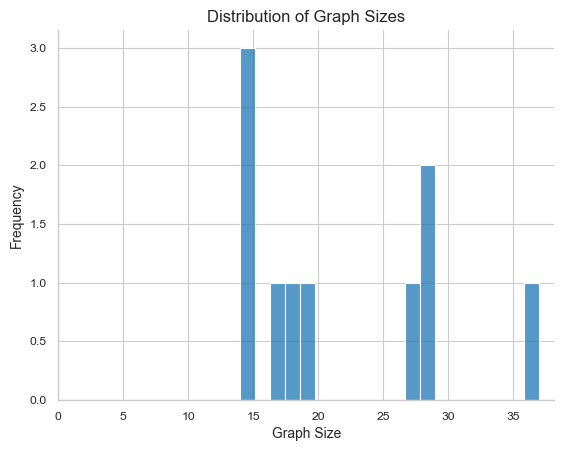

['necur', 'fakeav', 'sednit', 'waledac', 'bebloh', 'turla', 'gatak', 'mytob', 'orcus', 'buhtrap']


,Name,Graph Size with all sentence,Graph Size with only CTI sentence,Rate of CTI sentence in the graph
2,necur,37.0,3.0,8.11%
3,fakeav,28.0,15.0,53.57%
4,sednit,28.0,6.0,21.43%
5,waledac,27.0,0.0,0.00%
6,bebloh,19.0,5.0,26.32%
8,turla,18.0,5.0,27.78%
7,gatak,17.0,3.0,17.65%
1,mytob,15.0,0.0,0.00%
9,orcus,15.0,0.0,0.00%
0,buhtrap,14.0,2.0,14.29%


In [35]:
#2 Based on search_names_in_sub_obj, search the subgraph, draw the distribution graph and the table
overall_triple_search = []

for cve in tqdm.tqdm(search_names_in_sub_obj):
    overall_triple_search.append(search_subgraph(keywords=[cve],triples=all_triples,jump_length=1,allow_noentity_of_keywordedge=False))

overall_size=[]
for i in overall_triple_search:
    kg = build_graph(i[3])
    size=kg.number_of_nodes()+kg.number_of_edges()
    kg_cti = build_graph(i[4])
    size_cti=kg_cti.number_of_nodes()+kg_cti.number_of_edges()
    overall_size.append([i[0],size,size_cti])

overall_triple=[[i[0]]+i[3:5] for i in overall_triple_search]
#Sort each subgraph by size
cve_graph_size:pd.DataFrame = pd.DataFrame(overall_size,columns=['cve','allmapsize','ctimapsize'])
cve_graph_size['rate_of_cti'] = cve_graph_size['ctimapsize']/cve_graph_size['allmapsize']
#sort by ctimapsize from large to small
cve_graph_size = cve_graph_size.sort_values(by='allmapsize',ascending=False)
#rename the column to 'Name' 'Graph Size with all sentence' 'Graph Size with only CTI sentence' 'Rate of CTI sentence in the graph'
cve_graph_size.columns = ['Name','Graph Size with all sentence','Graph Size with only CTI sentence','Rate of CTI sentence in the graph']
#''Rate of CTI sentence in the graph' to 2 decimal with %
cve_graph_size['Rate of CTI sentence in the graph'] = cve_graph_size['Rate of CTI sentence in the graph'].apply(lambda x: format(x, '.2%'))
#filter the 'Graph Size with all sentence' > 0
cve_graph_size = cve_graph_size[cve_graph_size['Graph Size with all sentence']>0]

#Draw the distribution graph of subgraph size and make the distribution table
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume the original dataframe is named 'df'

# Get the column with the sizes
sizes = cve_graph_size['Graph Size with all sentence']

# Set the style of the graph
sns.set_style("whitegrid")
sns.set_context("paper")

# Create a histogram plot
sns.histplot(data=sizes, kde=False, bins=20)

# Set the x-axis limit
plt.xlim(left=0)

# Add a title and x-label
plt.title("Distribution of Graph Sizes", fontsize=12)
plt.xlabel("Graph Size", fontsize=10)
plt.ylabel("Frequency", fontsize=10)

# Remove the top and right spines
sns.despine(top=True, right=True)

# Save the figure
plt.savefig('graph_sizes.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

#add the average size of the graph, the size of the graph with only CTI sentence, the rate of CTI sentence in the graph at the end of the table
cve_graph_size.loc['Average'] = cve_graph_size.mean()
cve_graph_size.loc['Average','Name'] = 'Average'
cve_graph_size.loc['Average','Rate of CTI sentence in the graph'] = format(cve_graph_size.loc['Average','Rate of CTI sentence in the graph'], '.2%')
cve_graph_size.loc['Average','Graph Size with all sentence'] = int(cve_graph_size.loc['Average','Graph Size with all sentence'])
cve_graph_size.loc['Average','Graph Size with only CTI sentence'] = int(cve_graph_size.loc['Average','Graph Size with only CTI sentence'])
#top10_cve_graph_size = cve_graph_size.head(10)
print(cve_graph_size.Name.values.tolist()[0:10])
cve_graph_size

In [ ]:
#Find the interconnected CVE node in the graph
data_frame=pd.DataFrame(columns=['Name','Connected CVE in all sentect graph','Connected CVE in CTI sentect graph'])

def graph_has_keyword(triples:list,keyword:str,notkeyword:str):
    final_bool = False 
    for triple in triples:
        #print(triple)
        if str(keyword) in str(triple.sub) and str(notkeyword) not in str(triple.sub):
            final_bool=True
        if str(keyword) in str(triple.obj) and str(notkeyword) not in str(triple.obj):
            final_bool=True
    return final_bool

def graph_keyword(triples:list,keyword:str,removekeyword=None):
    foundlist=set()
    for triple in triples:
        #print(triple)
        if str(keyword) in str(triple.sub):
            foundlist.add(triple.sub)
        if str(keyword) in str(triple.obj):
            foundlist.add(triple.obj)
    foundlist=list(foundlist)
    if removekeyword is not None:
        foundlist=[i for i in foundlist if removekeyword not in i]
    return foundlist
    

cves_linked_to_another=[]
for i in overall_triple:
    cve_name=i[0]
    subgraph=i[1]
    subgraphcti=i[2]
    if graph_has_keyword(subgraph,'cve',cve_name):
        cves_linked_to_another.append(cve_name)
    if len(graph_keyword(subgraph,'cve'))>1:
        #print(cve_name,graph_keyword(subgraph,'cve'))
        #add to dataframe
        connected_cves=graph_keyword(triples=subgraph,keyword='cve',removekeyword=' ')
        #remove cve_name itself
        connected_cves=[i for i in connected_cves if cve_name not in i]
        connected_cves_cti=graph_keyword(triples=subgraphcti,keyword='cve',removekeyword=' ')
        #remove cve_name itself
        connected_cves_cti=[i for i in connected_cves_cti if cve_name not in i]
        if len(connected_cves)>0:
            data_frame=data_frame.append({'Name':cve_name,'Connected CVE in all sentect graph':connected_cves,'Connected CVE in CTI sentect graph':connected_cves_cti},ignore_index=True)


print('---------------')

cves_linked_to_another_cti=[]
for i in overall_triple:
    cve_name=i[0]
    subgraph=i[1]
    subgraphcti=i[2]
    if graph_has_keyword(subgraphcti,'cve',cve_name):
        cves_linked_to_another_cti.append(cve_name)

#sort by Name	
data_frame=data_frame.sort_values(by=['Name'])

size_of_CVE_has_connected_CVE_in_all_graph=len(data_frame)
size_of_CVE_has_connected_CVE_in_CTI_graph=len(data_frame[data_frame['Connected CVE in CTI sentect graph'].map(len)>0])
print('size_of_CVE_has_connected_CVE_in_all_graph',size_of_CVE_has_connected_CVE_in_all_graph,'size_of_CVE_has_connected_CVE_in_CTI_graph',size_of_CVE_has_connected_CVE_in_CTI_graph)


In [ ]:
#get all edge in the path between two CVE
linked=set()
for i in range(len(data_frame)):
    start_cve=data_frame['Name'][i]
    for j in data_frame['Connected CVE in all sentect graph'][i]:
        link_2cve=set()
        link_2cve.add(start_cve)
        link_2cve.add(j)
        linked.add(tuple(link_2cve))
print('size of linked',len(linked))

all_paths=set()
for i in linked:
    start_cve=i[0]
    end_cve=i[1]
    graph=build_graph(search_subgraph(keywords=[start_cve],triples=all_triples,jump_length=2,allow_noentity_of_keywordedge=True)[3]) # type: ignore
    G_undirected = graph.to_undirected()
    paths = nx.all_simple_paths(G_undirected, source=start_cve, target=end_cve)
    for path in paths:
        all_paths.add(tuple(path))
data_frame=pd.DataFrame(columns=['full path','id','raw_sent','sub','rel','obj'])
for i in all_paths:
    print(list(i))
    for m in range(len(list(i))-1):
        fullpath=str(list(i))
        target=list(i)[m]
        sec_target=list(i)[m+1]
        G=build_graph(search_subgraph(keywords=[target],triples=all_triples,jump_length=1,allow_noentity_of_keywordedge=False)[3]) # type: ignore
        data = G.nodes[target]
        for tri in data['mentions']:
            if sec_target in tri.sub or sec_target in tri.obj:
                #print(tri)
                #print(tri.article_id,'|',tri.raw_sent,'|',tri.sub,'|',tri.rel,'|',tri.obj)
                data_frame=data_frame.append({'full path':fullpath,'id':tri.article_id,'raw_sent':tri.raw_sent,'sub':tri.sub,'rel':tri.rel,'obj':tri.obj},ignore_index=True)

In [ ]:
#draw graph based on keyword
G=build_graph(search_subgraph(keywords=['keyword'],triples=all_triples,jump_length=1,allow_noentity_of_keywordedge=False)[3])
draw_graph(G)